In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from working.sea_breeze.load_model_data import *
import cartopy.crs as ccrs
from working.sea_breeze.coastline_funcs import rotate_u_v_coast

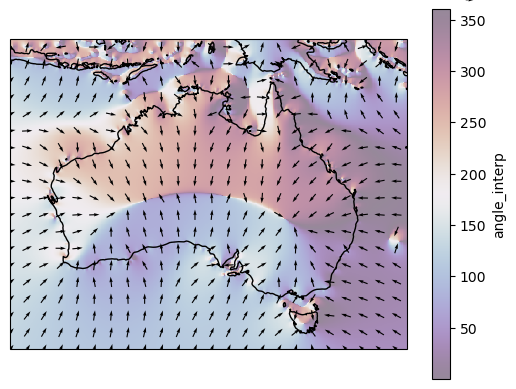

In [2]:
#Load coastline orientation angles
f = xr.open_dataset("/g/data/gb02/ab4502/coastline_data/barra_r_angles_v2.nc")

#Define angle of coastline orientation from N
theta=f.angle_interp   
#Rotate angle to be perpendicular to theta, pointing in the onshore direction (from E, i.e. mathamatical angle definition)
rotated_angle=(((theta)%360-90)%360) + 90   
#Define angle vectors of unit length
cx, cy = [-np.cos(np.deg2rad(rotated_angle)), np.sin(np.deg2rad(rotated_angle))]

#Plot the coastline angle orientation as a contour map, with unit vectors pointing onshore
ax=plt.axes(projection=ccrs.PlateCarree())
f.angle_interp.plot(cmap="twilight_shifted",alpha=0.5)
ax.coastlines()
xr.Dataset({"cx":cx,"cy":cy}).isel(lon=slice(0,-1,20),lat=slice(0,-1,20)).plot.quiver(x="lon",y="lat",u="cx",v="cy")

In [3]:
#To experiment with taking gradients, load some temperature, moisture, and wind data
barra_var = load_barra_variable(["tas","huss","uas","vas"],"2024-01-29 00:00", "2024-01-29 06:00","AUS-11","1hr",slice(-45.7,-5.0),slice(108,160))
unames = ["ua1000","ua925","ua850","ua700","ua600","ua500"]
vnames = ["va1000","va925","va850","va700","va600","va500"]
barrar_wind_ds = load_barra_wind_data(unames, vnames,"2024-01-29 00:00", "2024-01-29 06:00", "AUS-11", "1hr",slice(-45.7,-5.0),slice(108,160), "pressure")

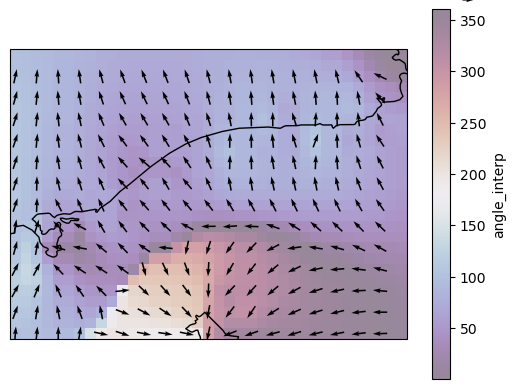

In [4]:
#Plot the coastline angle orientation as a contour map, with unit vectors pointing onshore
ax=plt.axes(projection=ccrs.PlateCarree())
f.angle_interp.sel(lat=slice(-40,-37),lon=slice(146,150)).plot(cmap="twilight_shifted",alpha=0.5)
ax.coastlines()
xr.Dataset({"cx":cx,"cy":cy}).sel(lat=slice(-40,-37),lon=slice(146,150)).isel(lon=slice(0,-1,2),lat=slice(0,-1,2)).plot.quiver(x="lon",y="lat",u="cx",v="cy")

In [5]:
#Get the surface winds perpendicular to the coast, firstly by rotating U and V 
_,vprime_uas1 = rotate_u_v_coast(barra_var["uas"]["uas"],barra_var["vas"]["vas"],f.angle_interp)

#Now by using the normal unit vectors
vprime_uas2 = ((barra_var["uas"]["uas"]*cx) + (barra_var["vas"]["vas"]*cy))

#Now for the pressure level winds
vprime_p = ((barrar_wind_ds["u"]*cx) + (barrar_wind_ds["v"]*cy))

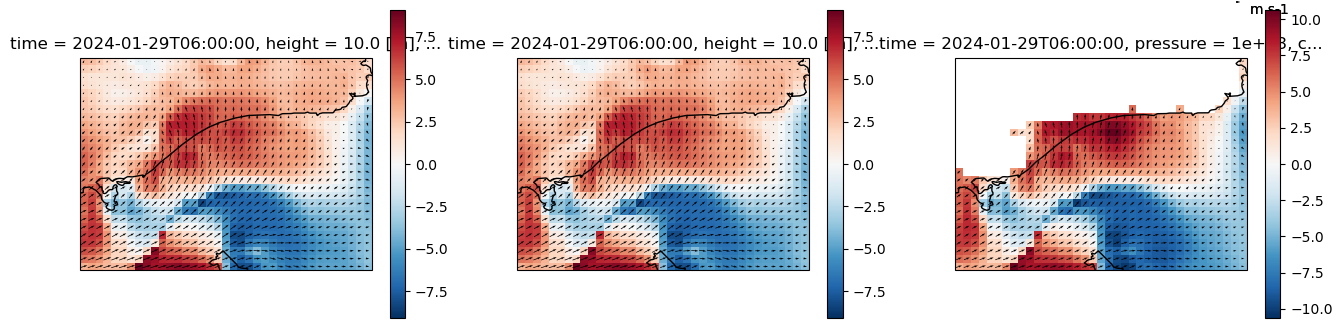

In [6]:
#Check that everything is working
plt.figure(figsize=[16,4])
ax=plt.subplot(1,3,1,projection=ccrs.PlateCarree())
vprime_uas1.sel(time="2024-01-29 06:00").sel(lat=slice(-40,-37),lon=slice(146,150)).plot()
xr.Dataset({"u":barra_var["uas"]["uas"],"v":barra_var["vas"]["vas"]}).sel(lat=slice(-40,-37),lon=slice(146,150),time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

ax=plt.subplot(1,3,2,projection=ccrs.PlateCarree())
vprime_uas2.sel(time="2024-01-29 06:00").sel(lat=slice(-40,-37),lon=slice(146,150)).plot()
xr.Dataset({"u":barra_var["uas"]["uas"],"v":barra_var["vas"]["vas"]}).sel(lat=slice(-40,-37),lon=slice(146,150),time="2024-01-29 06:00").plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

ax=plt.subplot(1,3,3,projection=ccrs.PlateCarree())
vprime_p.sel(time="2024-01-29 06:00",pressure=1000).sel(lat=slice(-40,-37),lon=slice(146,150)).plot()
barrar_wind_ds.sel(lat=slice(-40,-37),lon=slice(146,150),time="2024-01-29 06:00",pressure=1000).plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

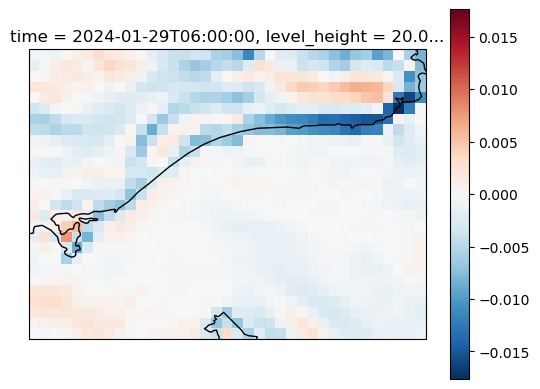

In [7]:
#Calculate cross-shore surface moisture gradient and plot

dq_dx = (barra_var["huss"]["huss"].differentiate(coord="lon")*cx+barra_var["huss"]["huss"].differentiate(coord="lat")*cy)

plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
dq_dx.sel(lat=slice(-40,-37),lon=slice(146,150),time="2024-01-29 06:00").plot()
ax.coastlines()

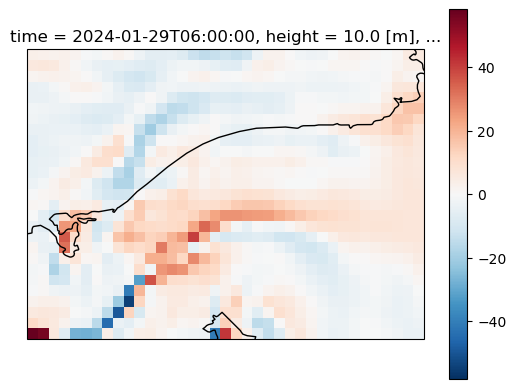

In [8]:
#Calculate cross-shore onshore wind gradient and plot

du_dx = (((vprime_uas1).differentiate(coord="lon")*cx+(vprime_uas1).differentiate(coord="lat")*cy))

ax=plt.axes(projection=ccrs.PlateCarree())
du_dx.sel(lat=slice(-40,-37),lon=slice(146,150),time="2024-01-29 06:00").plot()
ax.coastlines()

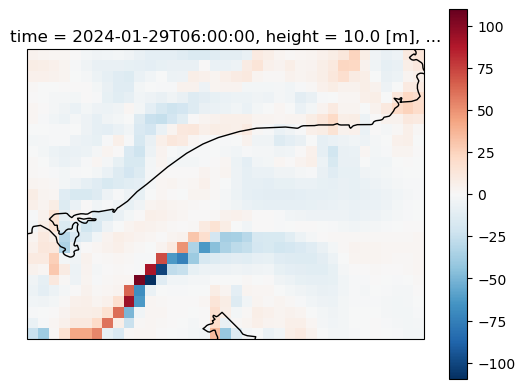

In [9]:
#Calculate the cross-shore gradient of the perurbation onshore wind

du_dx_pert = (((vprime_uas1 - vprime_p.mean("pressure")).differentiate(coord="lon")*cx+(vprime_uas1 - vprime_p.mean("pressure")).differentiate(coord="lat")*cy))

ax=plt.axes(projection=ccrs.PlateCarree())
du_dx_pert.sel(lat=slice(-40,-37),lon=slice(146,150),time="2024-01-29 06:00").plot()
ax.coastlines()

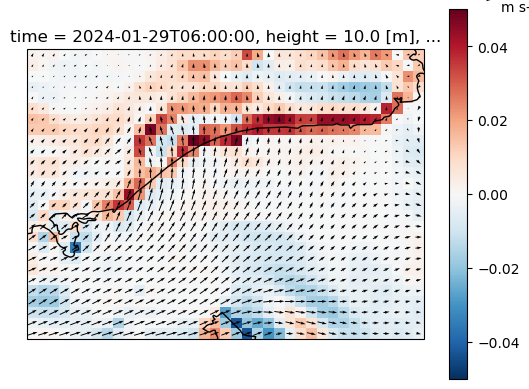

In [10]:
plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())

#dq_dc = (((barra_var["huss"]["huss"].sel(time="2024-01-29 06:00")).differentiate(coord="lon")*cx+(barra_var["huss"]["huss"].sel(time="2024-01-29 06:00")).differentiate(coord="lat")*cy))
#(-dq_dc * vprime.sel(time="2024-01-29 06:00")).sel(lat=slice(-40,-37),lon=slice(146,150)).plot()
(-dq_dx * vprime_uas1).sel(time="2024-01-29 06:00").sel(lat=slice(-40,-37),lon=slice(146,150)).plot()

xr.Dataset({"u":barra_var["uas"]["uas"].sel(time="2024-01-29 06:00"),"v":barra_var["vas"]["vas"].sel(time="2024-01-29 06:00")}).squeeze().sel(lat=slice(-40,-37),lon=slice(146,150)).plot.quiver(x="lon",y="lat",u="u",v="v")
ax.coastlines()

#This is cross-shore moisture advection

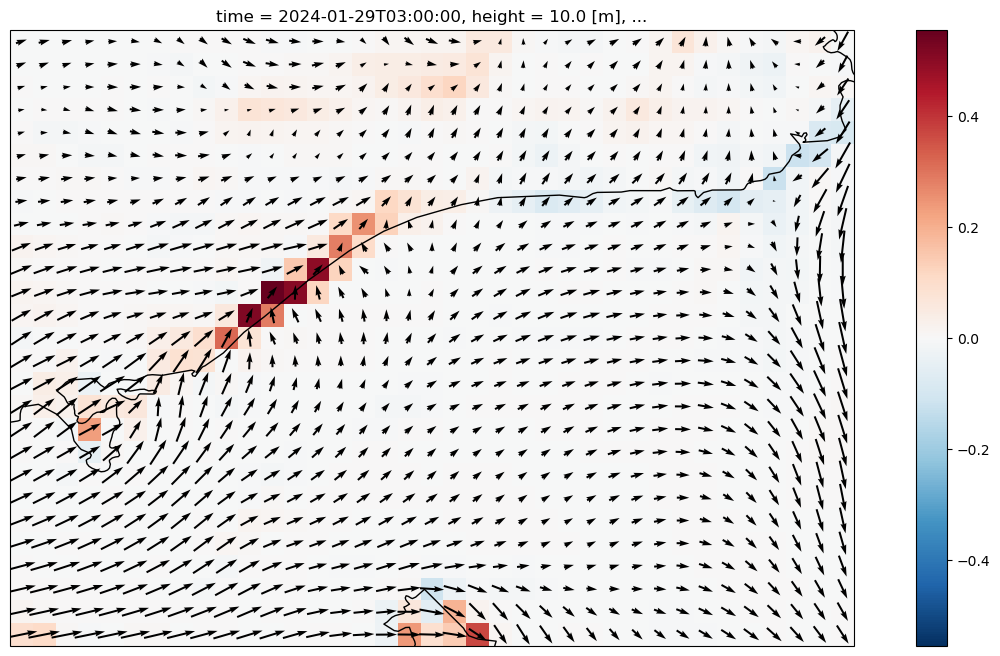

In [11]:
plt.figure(figsize=[16,8])
ax=plt.axes(projection=ccrs.PlateCarree())

t="2024-01-29 03:00"
(dq_dx * du_dx).sel(time=t,lat=slice(-40,-37),lon=slice(146,150)).plot()
xr.Dataset({"u":barra_var["uas"]["uas"],"v":barra_var["vas"]["vas"]}).squeeze().sel(lat=slice(-40,-37),lon=slice(146,150),time=t).plot.quiver(x="lon",y="lat",u="u",v="v",scale=200)
ax.coastlines()

#This is the rate of change of the moisture gradient in the cross-shore direction!
#Sort of a 1d frontogenesis function using only only convergence matters.
#See term1, equation 2 of Finkele et al. 1994.

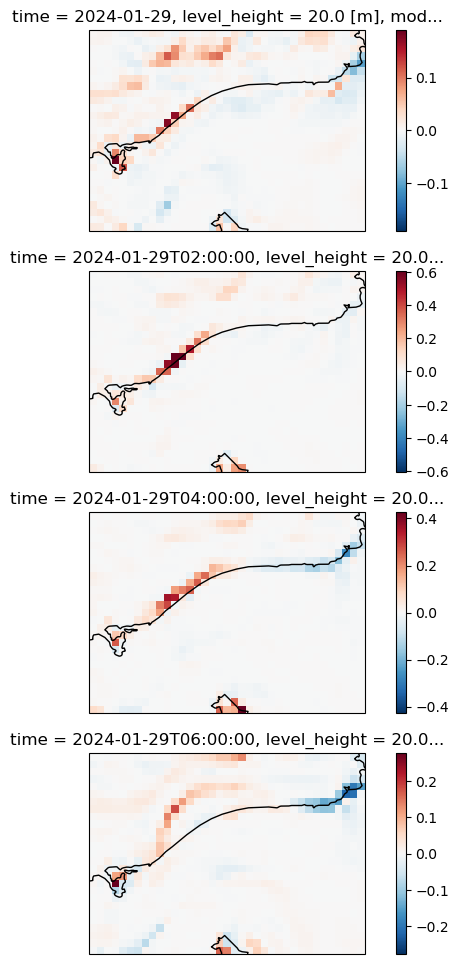

In [12]:
cnt=0
plt.figure(figsize=[8,12])
for t in [0,2,4,6]:
    ax=plt.subplot(4,1,cnt+1,projection=ccrs.PlateCarree())
    (dq_dx * du_dx).isel(time=t).sel(lat=slice(-40,-37),lon=slice(146,150)).plot()
    ax.coastlines()
    cnt=cnt+1

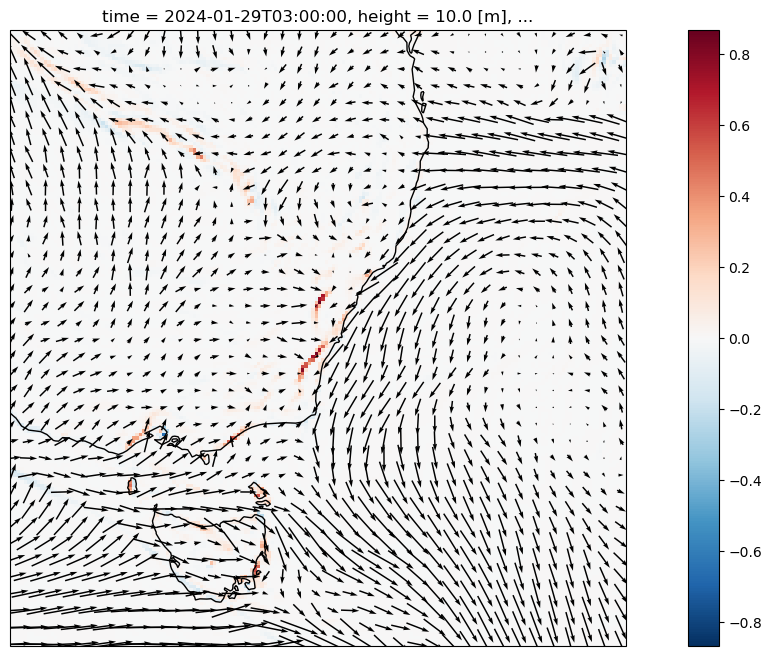

In [13]:
plt.figure(figsize=[16,8])
ax=plt.axes(projection=ccrs.PlateCarree())

t="2024-01-29 03:00"
(dq_dx * du_dx).sel(time=t,lat=slice(-45,-25),lon=slice(140,160)).plot()
xr.Dataset({"u":barra_var["uas"]["uas"],"v":barra_var["vas"]["vas"]}).squeeze().sel(lat=slice(-45,-25),lon=slice(140,160),time=t).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).plot.quiver(x="lon",y="lat",u="u",v="v",scale=200)
ax.coastlines()

#This is the rate of change of the moisture gradient in the cross-shore direction!
#Sort of a 1d frontogenesis function using only only convergence matters.
#See term1, equation 2 of Finkele et al. 1994.

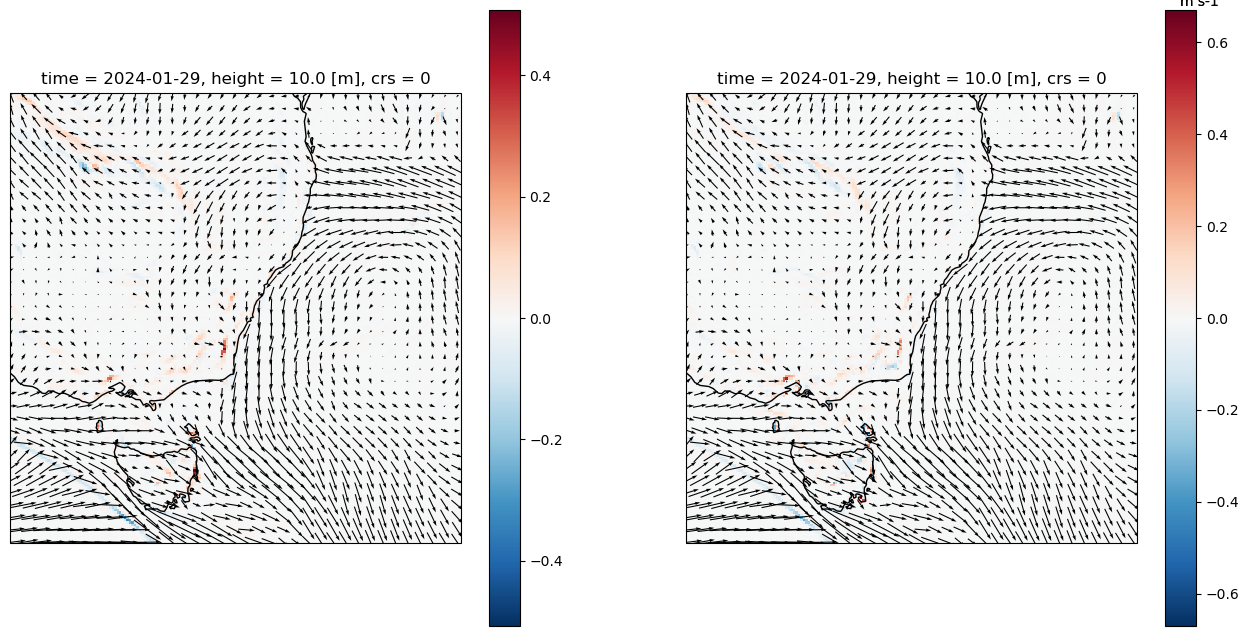

In [14]:
plt.figure(figsize=[16,8])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
t="2024-01-29 00:00"
(dq_dx * du_dx).sel(time=t,lat=slice(-45,-25),lon=slice(140,160)).plot()
xr.Dataset({"u":barra_var["uas"]["uas"],"v":barra_var["vas"]["vas"]}).squeeze().sel(lat=slice(-45,-25),lon=slice(140,160),time=t).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).plot.quiver(x="lon",y="lat",u="u",v="v",scale=200)
ax.coastlines()

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
(dq_dx * du_dx_pert).sel(time=t,lat=slice(-45,-25),lon=slice(140,160)).plot()
xr.Dataset({"u":barra_var["uas"]["uas"],"v":barra_var["vas"]["vas"]}).squeeze().sel(lat=slice(-45,-25),lon=slice(140,160),time=t).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).plot.quiver(x="lon",y="lat",u="u",v="v",scale=200)
ax.coastlines()

#This is the rate of change of the moisture gradient in the cross-shore direction!
#Sort of a 1d frontogenesis function using only only convergence matters.
#See term1, equation 2 of Finkele et al. 1994.

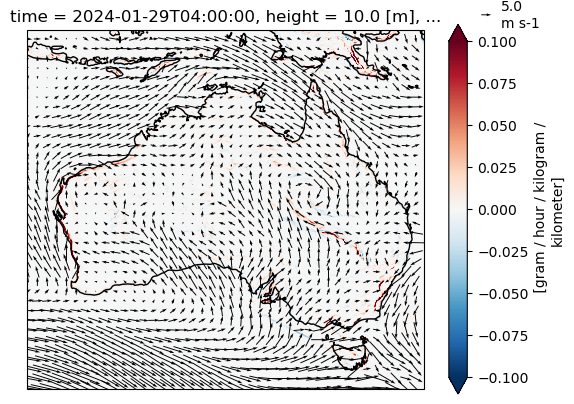

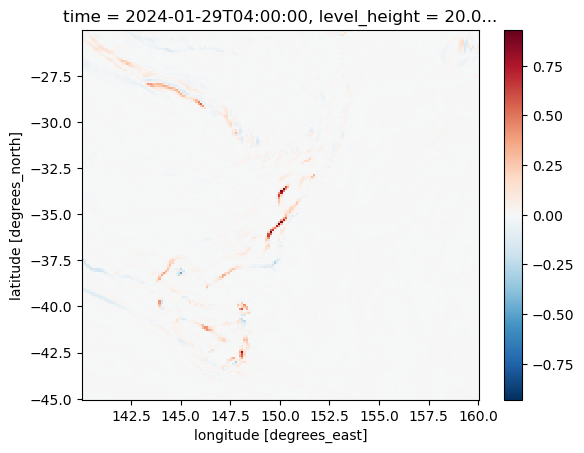

In [134]:
q=barra_var["huss"]["huss"]
u=barra_var["uas"]["uas"]
v=barra_var["vas"]["vas"]
t="2024-01-29 04:00"

#Define angle of coastline orientation from N
theta=f.angle_interp   
#Rotate angle to be perpendicular to theta, pointing in the onshore direction (from E, i.e. mathamatical angle definition)
rotated_angle=(((theta)%360-90)%360) + 90   
#Define angle vectors of unit length
cx, cy = [-np.cos(np.deg2rad(rotated_angle)), np.sin(np.deg2rad(rotated_angle))]

#Calculate the wind component perpendicular to the coast by using the normal unit vectors
vprime = ((u*cx) + (v*cy))

#Calculate cross-shore surface moisture gradient and plot
#dq_dx = (q.differentiate(coord="lon")*cx+q.differentiate(coord="lat")*cy)
dq_dx, dq_dy = mpcalc.geospatial_gradient((q * units.units("g/g")).metpy.convert_units("g/kg"), x_dim=q.get_axis_num("lon"), y_dim=q.get_axis_num("lat"))
dq_dc = (dq_dx*cx.values) + (dq_dy*cy.values)

#Calculate cross-shore gradient in onshore wind component 
dvprime_dx, dvprime_dy = mpcalc.geospatial_gradient(vprime*units.units("m/s"), x_dim=vprime.get_axis_num("lon"), y_dim=vprime.get_axis_num("lat"))
dvprime_dc = (dvprime_dx*cx.values) + (dvprime_dy*cy.values)

dq_conv = (dq_dc * dvprime_dc)
#dq_conv = (1 * dvprime_dc)
ax=plt.axes(projection=ccrs.PlateCarree())
xr.DataArray(dq_conv.to("g/kg/km/hr"),coords={"time":q.time,"lat":q.lat,"lon":q.lon}).sel(time=t,lat=slice(-50,-5),lon=slice(110,155)).plot(vmin=-.1,vmax=0.1,cmap="RdBu_r")
xr.Dataset({"u":barra_var["uas"]["uas"],"v":barra_var["vas"]["vas"]}).squeeze().sel(lat=slice(-50,-5),lon=slice(110,155),time=t).isel(lat=slice(0,-1,10),lon=slice(0,-1,10)).plot.quiver(x="lon",y="lat",u="u",v="v",scale=200)
ax.coastlines()

plt.figure()
vprime_uas2 = ((barra_var["uas"]["uas"]*cx) + (barra_var["vas"]["vas"]*cy))
dq_dx = (barra_var["huss"]["huss"].differentiate(coord="lon")*cx+barra_var["huss"]["huss"].differentiate(coord="lat")*cy)
du_dx = (((vprime_uas2).differentiate(coord="lon")*cx+(vprime_uas2).differentiate(coord="lat")*cy))
(dq_dx * du_dx).sel(time=t,lat=slice(-45,-25),lon=slice(140,160)).plot()
#(1 * du_dx).sel(time="2024-01-29 03:00",lat=slice(-40,-37),lon=slice(146,150)).plot()

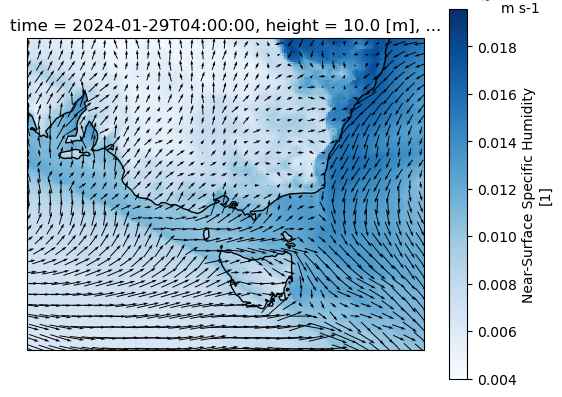

In [131]:
ax=plt.axes(projection=ccrs.PlateCarree())
q.sel(lat=slice(-50,-30),lon=slice(135,155),time=t).plot(cmap="Blues")
xr.Dataset({"u":barra_var["uas"]["uas"],"v":barra_var["vas"]["vas"]}).squeeze().sel(lat=slice(-50,-30),lon=slice(135,155),time=t).isel(lat=slice(0,-1,5),lon=slice(0,-1,5)).plot.quiver(x="lon",y="lat",u="u",v="v",scale=200)
ax.coastlines()